<a href="https://colab.research.google.com/github/HazemTebibi/ChatbotJuridiqueDS/blob/main/RAG_ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:

# SECTION 1: INSTALLATION


print("="*80)
print("INSTALLATION DES DÉPENDANCES")
print("="*80)

# 1. Install system dependencies first
!apt-get install -y poppler-utils  # Often needed for PDF processing

# 2. Install Python libraries
!pip install -q -U \
    langchain==0.3.0 \
    langchain-community==0.3.0 \
    langchain-huggingface \
    langchain-text-splitters \
    sentence-transformers \
    transformers \
    faiss-cpu \
    pypdf PyPDF2 pdfplumber \
    beautifulsoup4 lxml \
    chromadb \
    gradio==4.13.0 \
    python-dotenv \
    unidecode \
    pandas matplotlib seaborn \
    requests \
    huggingface-hub>=0.20.0

print("\n Installation terminée! Redémarrage du kernel si nécessaire...")


# SECTION 2: IMPORTS


import os
import sys
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

try:
    from langchain_text_splitters import RecursiveCharacterTextSplitter
except ImportError:
    from langchain.text_splitter import RecursiveCharacterTextSplitter

# Standard Imports
import re
import json
import pickle
import time
from typing import List, Dict, Tuple, Optional
from pathlib import Path
import requests

# Data Processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
from bs4 import BeautifulSoup
import PyPDF2
import pdfplumber

# Embeddings & Vector Stores
from langchain_community.vectorstores import FAISS
# Note: Using the specialized huggingface library is now preferred over community
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.documents import Document

# Interface
import gradio as gr

print("="*80)
print(f" Imports réussis!")
print(f"   Gradio version: {gr.__version__}")
print(f"   LangChain loaded successfully")
print("="*80)

INSTALLATION DES DÉPENDANCES
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.12).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.

 Installation terminée! Redémarrage du kernel si nécessaire...
 Imports réussis!
   Gradio version: 4.13.0
   LangChain loaded successfully


In [25]:

# SECTION 3: CONFIGURATION GLOBALE


print("="*80)
print("CONFIGURATION DU PROJET")
print("="*80)

class Config:
    """Configuration globale du projet"""

    # Chemins
    DATA_DIR = "./data"
    RAW_DIR = f"{DATA_DIR}/raw"
    PROCESSED_DIR = f"{DATA_DIR}/processed"
    VECTORSTORE_DIR = f"{DATA_DIR}/vectorstore"

    # Modèles
    EMBEDDING_MODEL = "dangvantuan/sentence-camembert-large"
    # Alternatives:
    # - "intfloat/multilingual-e5-large"
    # - "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"

    # Paramètres RAG
    CHUNK_SIZE = 800
    CHUNK_OVERLAP = 200
    TOP_K = 5

    # API LLM (optionnel - laissez vide pour mode simulation)
    try:
        LLM_API_KEY = userdata.get('OPEN_AI_KEY')  # Depuis Colab Secrets
    except:
        LLM_API_KEY = ""  # Fallback# Votre clé OpenAI/Anthropic/Mistral
    LLM_PROVIDER = "gemini"  # "openai", "anthropic", "mistral", "simulation"
    LLM_MODEL = "gemini-1.5-flash"

    # API PISTE (pour Legifrance - optionnel)
    PISTE_API_KEY = ""  # Obtenez-la sur https://api.gouv.fr/

    @classmethod
    def create_directories(cls):
        """Créer les répertoires nécessaires"""
        for directory in [cls.RAW_DIR, cls.PROCESSED_DIR, cls.VECTORSTORE_DIR]:
            Path(directory).mkdir(parents=True, exist_ok=True)
        print(f" Répertoires créés: {cls.DATA_DIR}")

Config.create_directories()
print()

CONFIGURATION DU PROJET
 Répertoires créés: ./data



In [26]:

# SECTION 4: MODULE D'EXTRACTION DES SOURCES JURIDIQUES


print("="*80)
print("MODULE D'EXTRACTION DES SOURCES")
print("="*80)

class LegalDataScraper:
    """Scraper pour extraire les données juridiques des sources officielles"""

    def __init__(self, output_dir: str = Config.RAW_DIR):
        self.output_dir = output_dir
        Path(output_dir).mkdir(parents=True, exist_ok=True)

        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
            'Accept-Language': 'fr-FR,fr;q=0.9',
        }

        self.session = requests.Session()
        self.session.headers.update(self.headers)

    def create_sample_corpus(self) -> Dict[str, Dict]:
        """
        Créer un corpus d'échantillon réaliste du Code du Travail
        Pour un projet réel, utilisez scrape_legifrance_api_piste()
        """

        print(" Création d'un corpus d'échantillon du Code du Travail...")

        articles = {
            "L3121-27": {
                "id": "L3121-27",
                "titre": "Durée légale du travail",
                "content": """La durée légale de travail effectif des salariés à temps complet est fixée à trente-cinq heures par semaine.

Dans les professions et les entreprises déterminées par décret en Conseil d'Etat où les conditions de travail sont particulièrement pénibles ou dangereuses, la durée légale hebdomadaire peut être réduite sans que cette réduction puisse excéder deux heures.

Les heures supplémentaires et leur rémunération ou leur compensation en repos sont régies par les articles L. 3121-28 à L. 3121-39.""",
                "source": "Code du Travail - Article L3121-27",
                "section": "Durée du travail",
                "date_version": "2024-01-01"
            },

            "L1221-1": {
                "id": "L1221-1",
                "titre": "Contrat de travail",
                "content": """Le contrat de travail est soumis aux règles du droit commun. Il peut être établi selon les formes que les parties contractantes décident d'adopter.

Le contrat de travail à durée indéterminée est la forme normale et générale de la relation de travail. Toutefois, le contrat de travail peut comporter un terme fixé avec précision dès sa conclusion ou résultant de la réalisation de l'objet pour lequel il est conclu dans les cas et conditions prévus au chapitre II.""",
                "source": "Code du Travail - Article L1221-1",
                "section": "Contrat de travail",
                "date_version": "2024-01-01"
            },

            "L1234-1": {
                "id": "L1234-1",
                "titre": "Modes de rupture du contrat",
                "content": """La rupture du contrat de travail à durée indéterminée peut résulter :
1° De la volonté de l'employeur, sous réserve des dispositions du présent titre ;
2° De la volonté du salarié ;
3° D'un accord entre l'employeur et le salarié, dans les conditions définies aux articles L. 1237-11 à L. 1237-16.

Le contrat de travail peut également être rompu dans le cadre d'une procédure de licenciement économique ou pour motif personnel, sous réserve du respect des procédures légales.""",
                "source": "Code du Travail - Article L1234-1",
                "section": "Rupture du contrat",
                "date_version": "2024-01-01"
            },

            "L3141-1": {
                "id": "L3141-1",
                "titre": "Droit au congé payé",
                "content": """Tout salarié a droit chaque année à un congé payé à la charge de l'employeur.

La durée du congé payé annuel est calculée à raison de deux jours et demi ouvrables par mois de travail effectif accompli au cours de la période de référence, sans que la durée totale du congé exigible puisse excéder trente jours ouvrables.

Le congé peut être fractionné, avec l'accord du salarié ou en application d'un accord collectif.""",
                "source": "Code du Travail - Article L3141-1",
                "section": "Congés payés",
                "date_version": "2024-01-01"
            },

            "L1225-17": {
                "id": "L1225-17",
                "titre": "Congé de maternité",
                "content": """La salariée a le droit de bénéficier d'un congé de maternité pendant une période qui commence six semaines avant la date présumée de l'accouchement et se termine dix semaines après la date de celui-ci.

La salariée peut reporter après la naissance de l'enfant une partie du congé auquel elle a droit. La période de suspension de son contrat de travail ne peut débuter plus de deux semaines avant la date présumée de l'accouchement et se terminer moins de six semaines après la date de celui-ci.

Lorsqu'une pathologie est attestée par un certificat médical comme résultant de la grossesse ou de l'accouchement, la période de suspension du contrat de travail est augmentée de la durée de l'arrêt de travail prescrit.""",
                "source": "Code du Travail - Article L1225-17",
                "section": "Maternité et parentalité",
                "date_version": "2024-01-01"
            },

            "L1132-1": {
                "id": "L1132-1",
                "titre": "Interdiction des discriminations",
                "content": """Aucune personne ne peut être écartée d'une procédure de recrutement ou de l'accès à un stage ou à une période de formation en entreprise, aucun salarié ne peut être sanctionné, licencié ou faire l'objet d'une mesure discriminatoire, directe ou indirecte, notamment en matière de rémunération, au sens de l'article L. 3221-3, de mesures d'intéressement ou de distribution d'actions, de formation, de reclassement, d'affectation, de qualification, de classification, de promotion professionnelle, de mutation ou de renouvellement de contrat en raison de son origine, de son sexe, de ses mœurs, de son orientation sexuelle, de son identité de genre, de son âge, de sa situation de famille ou de sa grossesse, de ses caractéristiques génétiques, de la particulière vulnérabilité résultant de sa situation économique, apparente ou connue de son auteur, de son appartenance ou de sa non-appartenance, vraie ou supposée, à une ethnie, une nation ou une prétendue race, de ses opinions politiques, de ses activités syndicales ou mutualistes, de ses convictions religieuses, de son apparence physique, de son nom de famille, de son lieu de résidence ou de sa domiciliation bancaire, ou en raison de son état de santé, de sa perte d'autonomie ou de son handicap, de sa capacité à s'exprimer dans une langue autre que le français.""",
                "source": "Code du Travail - Article L1132-1",
                "section": "Discriminations",
                "date_version": "2024-01-01"
            },

            "L1152-1": {
                "id": "L1152-1",
                "titre": "Harcèlement moral",
                "content": """Aucun salarié ne doit subir les agissements répétés de harcèlement moral qui ont pour objet ou pour effet une dégradation de ses conditions de travail susceptible de porter atteinte à ses droits et à sa dignité, d'altérer sa santé physique ou mentale ou de compromettre son avenir professionnel.

Le harcèlement moral peut se manifester par des comportements, paroles, actes, gestes ou écrits répétés ayant un caractère dégradant ou humiliant. Ces agissements peuvent provenir d'une ou plusieurs personnes, qu'elles soient ou non en position hiérarchique vis-à-vis de la victime.""",
                "source": "Code du Travail - Article L1152-1",
                "section": "Harcèlement",
                "date_version": "2024-01-01"
            },

            "L2412-1": {
                "id": "L2412-1",
                "titre": "Temps de délégation",
                "content": """Le temps passé en délégation par les représentants du personnel est de plein droit considéré comme temps de travail et payé à l'échéance normale.

Les représentants du personnel bénéficient du temps nécessaire à l'exercice de leurs fonctions dans les limites d'une durée qui, sauf circonstances exceptionnelles, ne peut excéder dix heures par mois dans les entreprises ou établissements de moins de cinquante salariés et quinze heures par mois dans les entreprises ou établissements de cinquante salariés et plus.

Le crédit d'heures peut être utilisé cumulativement dans la limite de douze mois.""",
                "source": "Code du Travail - Article L2412-1",
                "section": "Représentation du personnel",
                "date_version": "2024-01-01"
            },

            "L1242-2": {
                "id": "L1242-2",
                "titre": "Cas de recours au CDD",
                "content": """Sous réserve des dispositions de l'article L. 1242-3, un contrat de travail à durée déterminée ne peut être conclu que pour l'exécution d'une tâche précise et temporaire et seulement dans les cas suivants :

1° Remplacement d'un salarié en cas d'absence, de passage provisoire à temps partiel, de suspension de son contrat de travail, de départ définitif précédant la suppression de son poste de travail après consultation du comité social et économique, ou d'attente de l'entrée en service effective du salarié recruté par contrat à durée indéterminée appelé à le remplacer ;

2° Accroissement temporaire de l'activité de l'entreprise ;

3° Emplois à caractère saisonnier ou pour lesquels, dans certains secteurs d'activité définis par décret ou par voie de convention ou d'accord collectif étendu, il est d'usage constant de ne pas recourir au contrat de travail à durée indéterminée en raison de la nature de l'activité exercée et du caractère par nature temporaire de ces emplois.""",
                "source": "Code du Travail - Article L1242-2",
                "section": "CDD",
                "date_version": "2024-01-01"
            },

            "L1233-3": {
                "id": "L1233-3",
                "titre": "Licenciement économique",
                "content": """Constitue un licenciement pour motif économique le licenciement effectué par un employeur pour un ou plusieurs motifs non inhérents à la personne du salarié résultant d'une suppression ou transformation d'emploi ou d'une modification, refusée par le salarié, d'un élément essentiel du contrat de travail, consécutives notamment à des difficultés économiques ou à des mutations technologiques.

Les difficultés économiques sont caractérisées soit par l'évolution significative d'au moins un indicateur économique tel qu'une baisse des commandes ou du chiffre d'affaires, des pertes d'exploitation ou une dégradation de la trésorerie ou de l'excédent brut d'exploitation, soit par tout autre élément de nature à justifier de ces difficultés.""",
                "source": "Code du Travail - Article L1233-3",
                "section": "Licenciement économique",
                "date_version": "2024-01-01"
            }
        }

        # Sauvegarder
        output_path = f"{self.output_dir}/code_travail_sample.json"
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(articles, f, ensure_ascii=False, indent=2)

        print(f" {len(articles)} articles créés: {output_path}")
        return articles

    def create_cnil_sample(self) -> List[Dict]:
        """Créer un échantillon de guides CNIL"""

        print(" Création d'échantillons CNIL...")

        guides = [
            {
                "title": "Guide pratique : Les données personnelles au travail",
                "content": """Les employeurs collectent de nombreuses données sur leurs salariés. Ces données doivent être traitées dans le respect du RGPD.

Données collectables :
- État civil, identité, données d'identification
- Vie professionnelle (CV, diplômes, formation)
- Informations relatives aux contrats de travail

Principes à respecter :
1. Finalité déterminée : Les données doivent être collectées pour un objectif précis
2. Minimisation : Seules les données nécessaires peuvent être collectées
3. Durée de conservation limitée
4. Sécurité et confidentialité

Droits des salariés :
- Droit d'accès aux données
- Droit de rectification
- Droit à l'effacement (sous conditions)
- Droit d'opposition""",
                "source": "CNIL - Guide Employeur",
                "url": "https://www.cnil.fr/fr/",
                "date": "2024-01-01"
            },
            {
                "title": "Surveillance des salariés et vie privée",
                "content": """La surveillance des salariés doit respecter un équilibre entre les intérêts légitimes de l'employeur et les droits des salariés.

Dispositifs de surveillance autorisés :
- Contrôle du temps de travail (badgeuse)
- Vidéosurveillance des locaux (avec restrictions)
- Géolocalisation des véhicules professionnels

Obligations de l'employeur :
1. Information préalable des salariés
2. Consultation du CSE
3. Déclaration à la CNIL si nécessaire
4. Proportionnalité des mesures

Interdictions :
- Surveillance constante et excessive
- Surveillance des zones de repos
- Collecte de données sensibles sans justification""",
                "source": "CNIL - Guide Surveillance",
                "url": "https://www.cnil.fr/fr/",
                "date": "2024-01-01"
            }
        ]

        output_path = f"{self.output_dir}/cnil_guides.json"
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(guides, f, ensure_ascii=False, indent=2)

        print(f" {len(guides)} guides CNIL créés: {output_path}")
        return guides

    def scrape_legifrance_api_piste(self, api_key: str = None, max_articles: int = 100) -> Dict:
        """
        Extraire via API PISTE (si clé API disponible)
        """
        if not api_key:
            print("  Pas de clé API PISTE - utilisation du corpus d'échantillon")
            return self.create_sample_corpus()

        print(f" Extraction via API PISTE...")
        # TODO: Implémenter l'appel API réel
        # Pour l'instant, retourner le corpus d'échantillon
        return self.create_sample_corpus()

    def extract_from_local_pdf(self, pdf_path: str) -> Dict:
        """Extraire le texte d'un PDF local"""

        print(f" Extraction du PDF: {pdf_path}")

        try:
            text = ""
            with pdfplumber.open(pdf_path) as pdf:
                for i, page in enumerate(pdf.pages):
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text + "\n"

            return {
                "filename": os.path.basename(pdf_path),
                "content": text,
                "source": f"PDF Local - {os.path.basename(pdf_path)}",
                "date_extraction": datetime.now().isoformat()
            }
        except Exception as e:
            print(f" Erreur extraction PDF: {e}")
            return None

print(" Module d'extraction créé\n")


MODULE D'EXTRACTION DES SOURCES
 Module d'extraction créé



In [27]:

# SECTION 5: EXTRACTION DES DONNÉES


print("="*80)
print("EXTRACTION DES DONNÉES JURIDIQUES")
print("="*80)

scraper = LegalDataScraper()

# Créer le corpus
code_travail = scraper.create_sample_corpus()
cnil_guides = scraper.create_cnil_sample()

print(f"\n Corpus créé:")
print(f"  • Code du Travail: {len(code_travail)} articles")
print(f"  • Guides CNIL: {len(cnil_guides)} documents")
print()


EXTRACTION DES DONNÉES JURIDIQUES
 Création d'un corpus d'échantillon du Code du Travail...
 10 articles créés: ./data/raw/code_travail_sample.json
 Création d'échantillons CNIL...
 2 guides CNIL créés: ./data/raw/cnil_guides.json

 Corpus créé:
  • Code du Travail: 10 articles
  • Guides CNIL: 2 documents



In [28]:

# SECTION 6: PRÉTRAITEMENT DES DONNÉES


print("="*80)
print("PRÉTRAITEMENT DES DONNÉES")
print("="*80)

class TextPreprocessor:
    """Prétraitement et chunking des documents juridiques"""

    @staticmethod
    def clean_text(text: str) -> str:
        """Nettoyer le texte"""
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\n+', '\n', text)
        return text.strip()

    @staticmethod
    def prepare_documents_from_sources(code_travail: Dict, cnil_guides: List[Dict]) -> List[Dict]:
        """Préparer tous les documents sources"""

        documents = []

        # Code du Travail
        for article_id, article_data in code_travail.items():
            documents.append({
                'article': article_id,
                'titre': article_data.get('titre', ''),
                'content': article_data['content'],
                'source': article_data['source'],
                'type': 'article_code',
                'section': article_data.get('section', '')
            })

        # Guides CNIL
        for guide in cnil_guides:
            documents.append({
                'article': 'CNIL',
                'titre': guide['title'],
                'content': guide['content'],
                'source': guide['source'],
                'type': 'guide',
                'section': 'CNIL'
            })

        return documents

    @staticmethod
    def chunk_documents(documents: List[Dict],
                       chunk_size: int = Config.CHUNK_SIZE,
                       chunk_overlap: int = Config.CHUNK_OVERLAP) -> List[Document]:
        """Découper les documents en chunks"""

        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
            separators=["\n\n", "\n", ". ", " ", ""]
        )

        chunked_docs = []

        for doc in documents:
            titre = doc.get('titre', '')
            content = doc['content']

            # Ajouter le titre au début du contenu
            full_content = f"{titre}\n\n{content}" if titre else content

            # Pour les articles de loi, garder l'article entier si possible
            if len(full_content) <= chunk_size and doc['type'] == 'article_code':
                chunked_docs.append(
                    Document(
                        page_content=full_content,
                        metadata={
                            'article': doc.get('article', 'N/A'),
                            'titre': titre,
                            'source': doc['source'],
                            'type': doc['type'],
                            'section': doc.get('section', '')
                        }
                    )
                )
            else:
                # Découper si trop long
                chunks = text_splitter.split_text(full_content)
                for i, chunk in enumerate(chunks):
                    chunked_docs.append(
                        Document(
                            page_content=chunk,
                            metadata={
                                'article': doc.get('article', 'N/A'),
                                'titre': titre,
                                'source': doc['source'],
                                'chunk_id': i,
                                'total_chunks': len(chunks),
                                'type': doc['type'],
                                'section': doc.get('section', '')
                            }
                        )
                    )

        return chunked_docs

# Préparer et chunker les documents
preprocessor = TextPreprocessor()
documents = preprocessor.prepare_documents_from_sources(code_travail, cnil_guides)
chunks = preprocessor.chunk_documents(documents)

print(f" Documents préparés: {len(documents)}")
print(f" Chunks créés: {len(chunks)}")
print(f" Taille moyenne des chunks: {np.mean([len(c.page_content) for c in chunks]):.0f} caractères")
print()

PRÉTRAITEMENT DES DONNÉES
 Documents préparés: 12
 Chunks créés: 16
 Taille moyenne des chunks: 542 caractères



In [29]:

# SECTION 7: CRÉATION DE LA BASE VECTORIELLE


print("="*80)
print("CRÉATION DE LA BASE VECTORIELLE")
print("="*80)

class VectorStoreManager:
    """Gestion de la base vectorielle FAISS"""

    def __init__(self, model_name: str = Config.EMBEDDING_MODEL):
        print(f" Chargement du modèle d'embeddings...")
        print(f"   Modèle: {model_name}")

        self.embeddings = HuggingFaceEmbeddings(
            model_name=model_name,
            model_kwargs={'device': 'cpu'},
            encode_kwargs={'normalize_embeddings': True}
        )
        self.vectorstore = None
        print(" Modèle chargé!")

    def create_vectorstore(self, documents: List[Document]) -> FAISS:
        """Créer la base vectorielle"""
        print(f" Indexation de {len(documents)} documents...")

        self.vectorstore = FAISS.from_documents(
            documents=documents,
            embedding=self.embeddings
        )

        print(" Base vectorielle créée!")
        return self.vectorstore

    def save_vectorstore(self, path: str = Config.VECTORSTORE_DIR):
        """Sauvegarder la base vectorielle"""
        if self.vectorstore:
            self.vectorstore.save_local(path)
            print(f" Base sauvegardée: {path}")

    def load_vectorstore(self, path: str = Config.VECTORSTORE_DIR):
        """Charger la base vectorielle"""
        try:
            self.vectorstore = FAISS.load_local(
                path,
                self.embeddings,
                allow_dangerous_deserialization=True
            )
            print(f" Base chargée: {path}")
            return self.vectorstore
        except Exception as e:
            print(f" Erreur chargement: {e}")
            return None

    def search(self, query: str, k: int = Config.TOP_K) -> List[Tuple[Document, float]]:
        """Rechercher les documents similaires"""
        if not self.vectorstore:
            raise ValueError("Base vectorielle non initialisée!")

        results = self.vectorstore.similarity_search_with_score(query, k=k)
        return results

# Créer la base vectorielle
vector_manager = VectorStoreManager()
vectorstore = vector_manager.create_vectorstore(chunks)
vector_manager.save_vectorstore()

print()


CRÉATION DE LA BASE VECTORIELLE
 Chargement du modèle d'embeddings...
   Modèle: dangvantuan/sentence-camembert-large


 Modèle chargé!
 Indexation de 16 documents...
 Base vectorielle créée!
 Base sauvegardée: ./data/vectorstore



In [30]:

# SECTION 8: GESTIONNAIRE LLM


print("="*80)
print("CONFIGURATION DU LLM")
print("="*80)

import re

class LLMHandler:
    """Gestionnaire pour les appels au LLM"""

    def __init__(self, provider: str = Config.LLM_PROVIDER, api_key: str = None):
        self.provider = provider
        self.api_key = api_key or Config.LLM_API_KEY

        if not self.api_key:
            print("  Mode simulation activé (clé API absente)")
            self.use_simulation = True
        else:
            print(f" LLM configuré : {provider} (clé API trouvée)")
            self.use_simulation = False

    def generate_response(self, query: str, context: str) -> str:
        """Générer une réponse"""

        prompt = self._create_prompt(query, context)

        if self.use_simulation:
            return self._simulate_response(query, context)

        try:
            if self.provider == "openai":
                return self._call_openai(prompt)
            elif self.provider == "anthropic":
                return self._call_anthropic(prompt)
            else:
                return self._simulate_response(query, context)

        except Exception as e:
            print(f" Erreur LLM: {e}")
            return self._simulate_response(query, context)

    def _create_prompt(self, query: str, context: str) -> str:
        """Créer le prompt système"""

        """Créer le prompt système"""

        prompt = f"""Tu es un assistant juridique spécialisé EXCLUSIVEMENT en droit du travail français.

        RÈGLES STRICTES À RESPECTER :

        1. PÉRIMÈTRE STRICT : Tu ne peux répondre QU'aux questions sur :
          - Contrats de travail (CDI, CDD)
          - Durée du travail, heures supplémentaires
          - Congés (payés, maternité, maladie)
          - Rupture du contrat (démission, licenciement)
          - Harcèlement et discrimination au travail
          - Représentation du personnel
          - Protection des données des salariés (CNIL/RGPD au travail)

        2. HORS PÉRIMÈTRE (TU DOIS REFUSER) :
          - Création d'entreprise (SARL, SAS, etc.)
          - Droit civil (mariage, divorce, succession)
          - Droit pénal
          - Fiscalité et impôts
          - Droit commercial
          - Questions générales non liées au travail

        3. SI LA QUESTION EST HORS PÉRIMÈTRE :
          Réponds EXACTEMENT : "Je suis désolé, mais cette question concerne [domaine identifié] et sort du cadre du droit du travail. Je ne peux répondre qu'aux questions relatives aux relations entre employeurs et salariés. Pour cette question, veuillez consulter un avocat spécialisé en [domaine concerné]."

        4. SI LA QUESTION EST DANS LE PÉRIMÈTRE :
          - Base-toi UNIQUEMENT sur les extraits juridiques fournis
          - Cite TOUJOURS précisément les articles
          - Structure ta réponse clairement

        CONTEXTE JURIDIQUE :
        {context}

        QUESTION DE L'UTILISATEUR :
        {query}

        ANALYSE D'ABORD : Cette question concerne-t-elle le droit du travail (relations employeur-salarié) ? Si NON, refuse poliment.

        RÉPONSE :"""
        return prompt

    def _call_openai(self, prompt: str) -> str:
        """Appeler l'API OpenAI"""
        import openai

        openai.api_key = self.api_key

        response = openai.ChatCompletion.create(
            model=Config.LLM_MODEL,
            messages=[
                {"role": "system", "content": "Tu es un assistant juridique spécialisé en droit du travail français."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3,
            max_tokens=1000
        )

        return response.choices[0].message.content

    def _call_anthropic(self, prompt: str) -> str:
        """Appeler l'API Anthropic Claude"""
        import anthropic

        client = anthropic.Anthropic(api_key=self.api_key)

        response = client.messages.create(
            model="claude-3-sonnet-20240229",
            max_tokens=1000,
            temperature=0.3,
            messages=[
                {"role": "user", "content": prompt}
            ]
        )

        return response.content[0].text

    def _simulate_response(self, query: str, context: str) -> str:
        """Mode simulation (sans API)"""

        articles = re.findall(r'Article (L[\d-]+)', context)

        if not articles:
            return (
                "Je ne dispose pas d'information suffisante dans le contexte fourni.\n\n"
                " Ceci est une réponse informative et ne constitue pas un avis juridique.\n"
                "Veuillez consulter un avocat pour un conseil personnalisé."
            )

        response_parts = []

        response_parts.append("Voici les informations extraites du Code du Travail :\n\n")

        response_parts.append(context.strip())

        response_parts.append("\n\n📚 Articles cités :")
        for art in sorted(set(articles))[:3]:
            response_parts.append(f"\n • Article {art}")

        response_parts.append(
            "\n\n Ceci est une réponse automatique basée sur les extraits fournis. "
            "Pour un avis juridique personnalisé, consultez un avocat."
        )

        return "".join(response_parts)


# Initialisation
llm_handler = LLMHandler()
print()


CONFIGURATION DU LLM
  Mode simulation activé (clé API absente)



In [31]:

# SECTION 9: PIPELINE RAG COMPLET


print("="*80)
print("CRÉATION DU PIPELINE RAG")
print("="*80)

class RAGPipeline:
    """Pipeline RAG complet pour le chatbot juridique"""

    def __init__(self, vector_manager: VectorStoreManager, llm_handler: LLMHandler):
        self.vector_manager = vector_manager
        self.llm_handler = llm_handler
        self.conversation_history = []

    def process_query(self, query: str, top_k: int = Config.TOP_K) -> Dict:
        """
        Traiter une requête complète

        Returns:
            Dict avec 'response', 'sources', 'retrieved_docs', 'metadata'
        """

        # Validation
        if not query or len(query.strip()) < 3:
            return {
                'response': " Veuillez poser une question valide (minimum 3 caractères).",
                'sources': [],
                'retrieved_docs': [],
                'metadata': {'error': 'invalid_query'}
            }

        # Recherche vectorielle
        try:
            results = self.vector_manager.search(query, k=top_k)
        except Exception as e:
            return {
                'response': f" Erreur lors de la recherche: {str(e)}",
                'sources': [],
                'retrieved_docs': [],
                'metadata': {'error': 'search_failed'}
            }

        # Préparer le contexte
        context_parts = []
        sources = []
        retrieved_docs = []

        for doc, score in results:
            article = doc.metadata.get('article', 'N/A')
            source = doc.metadata.get('source', 'Source inconnue')
            titre = doc.metadata.get('titre', '')
            content = doc.page_content

            # Format du contexte
            context_part = f"[{source}]\n"
            if titre:
                context_part += f"Titre: {titre}\n"
            context_part += f"{content}"

            context_parts.append(context_part)

            if source not in sources:
                sources.append(source)

            retrieved_docs.append({
                'content': content,
                'source': source,
                'article': article,
                'titre': titre,
                'score': float(score),
                'metadata': doc.metadata
            })

        context = "\n\n---\n\n".join(context_parts)

        # Générer la réponse
        response = self.llm_handler.generate_response(query, context)

        # Historique
        self.conversation_history.append({
            'query': query,
            'response': response,
            'sources': sources,
            'timestamp': datetime.now().isoformat(),
            'num_docs_retrieved': len(retrieved_docs)
        })

        return {
            'response': response,
            'sources': sources,
            'retrieved_docs': retrieved_docs,
            'metadata': {
                'num_results': len(results),
                'avg_score': np.mean([score for _, score in results]),
                'timestamp': datetime.now().isoformat()
            }
        }

    def format_response(self, result: Dict) -> str:
        """Formater la réponse pour l'affichage"""

        response = result['response']
        sources = result['sources']

        formatted = f"{response}\n\n"

        if sources:
            formatted += "---\n\n"
            formatted += " **Documentation consultée :**\n"
            for i, source in enumerate(sources, 1):
                formatted += f"{i}. {source}\n"

        return formatted

    def get_statistics(self) -> Dict:
        """Statistiques du système"""
        return {
            'total_queries': len(self.conversation_history),
            'avg_sources_per_query': np.mean([len(h['sources']) for h in self.conversation_history]) if self.conversation_history else 0,
            'total_sources_consulted': sum([len(h['sources']) for h in self.conversation_history])
        }

# Créer le pipeline
rag_pipeline = RAGPipeline(vector_manager, llm_handler)
print(" Pipeline RAG créé et prêt!")
print()

CRÉATION DU PIPELINE RAG
 Pipeline RAG créé et prêt!



In [32]:

# SECTION 10: TESTS DU SYSTÈME


print("="*80)
print("TESTS DU PIPELINE")
print("="*80)

test_queries = [
    "Quelle est la durée légale du travail en France ?",
    "Quels sont les droits au congé payé ?",
    "Qu'est-ce que le harcèlement moral au travail ?",
    "Comment créer une SARL ?"  # Hors périmètre
]

print("\n Exécution de 4 tests...\n")

for i, query in enumerate(test_queries, 1):
    print(f"{'='*70}")
    print(f"TEST {i}: {query}")
    print(f"{'='*70}")

    result = rag_pipeline.process_query(query)
    formatted = rag_pipeline.format_response(result)

    print(formatted)
    print()

print(" Tests terminés!")
print()


TESTS DU PIPELINE

 Exécution de 4 tests...

TEST 1: Quelle est la durée légale du travail en France ?
Voici les informations extraites du Code du Travail :

[Code du Travail - Article L3121-27]
Titre: Durée légale du travail
Durée légale du travail

La durée légale de travail effectif des salariés à temps complet est fixée à trente-cinq heures par semaine.

Dans les professions et les entreprises déterminées par décret en Conseil d'Etat où les conditions de travail sont particulièrement pénibles ou dangereuses, la durée légale hebdomadaire peut être réduite sans que cette réduction puisse excéder deux heures.

Les heures supplémentaires et leur rémunération ou leur compensation en repos sont régies par les articles L. 3121-28 à L. 3121-39.

---

[Code du Travail - Article L2412-1]
Titre: Temps de délégation
Temps de délégation

Le temps passé en délégation par les représentants du personnel est de plein droit considéré comme temps de travail et payé à l'échéance normale.

Les représen

In [33]:

# SECTION 11: ÉVALUATION DU SYSTÈME


print("="*80)
print("ÉVALUATION DU SYSTÈME")
print("="*80)

class RAGEvaluator:
    """Évaluation de la qualité du RAG"""

    def __init__(self, rag_pipeline: RAGPipeline):
        self.rag = rag_pipeline

    def evaluate_retrieval_quality(self, test_cases: List[Dict]) -> Dict:
        """
        Évaluer la qualité du retrieval

        test_cases: [{'query': '...', 'expected_articles': ['L1234-1', ...]}]
        """

        precision_scores = []
        recall_scores = []

        for test in test_cases:
            query = test['query']
            expected = set(test['expected_articles'])

            result = self.rag.process_query(query)
            retrieved = set([
                doc['article']
                for doc in result['retrieved_docs']
                if doc['article'] != 'N/A'
            ])

            if len(retrieved) > 0:
                precision = len(expected & retrieved) / len(retrieved)
                precision_scores.append(precision)

            if len(expected) > 0:
                recall = len(expected & retrieved) / len(expected)
                recall_scores.append(recall)

        return {
            'precision': np.mean(precision_scores) if precision_scores else 0,
            'recall': np.mean(recall_scores) if recall_scores else 0,
            'f1_score': 2 * (np.mean(precision_scores) * np.mean(recall_scores)) / (np.mean(precision_scores) + np.mean(recall_scores)) if (precision_scores and recall_scores) else 0
        }

    def test_out_of_scope_handling(self, out_of_scope_queries: List[str]) -> float:
        """Tester la gestion des questions hors périmètre"""

        refusal_keywords = [
            "ne dispose pas",
            "ne sais pas",
            "pas d'information",
            "consulter un avocat",
            "conseil juridique"
        ]

        correct_refusals = 0

        for query in out_of_scope_queries:
            result = self.rag.process_query(query)
            response = result['response'].lower()

            # Vérifier si refus approprié
            if any(keyword in response for keyword in refusal_keywords):
                correct_refusals += 1

        return correct_refusals / len(out_of_scope_queries) if out_of_scope_queries else 0

# Cas de test
test_cases = [
    {'query': "Quelle est la durée légale du travail ?", 'expected_articles': ['L3121-27']},
    {'query': "Quels sont les droits au congé payé ?", 'expected_articles': ['L3141-1']},
    {'query': "Qu'est-ce que la discrimination ?", 'expected_articles': ['L1132-1']},
    {'query': "Comment fonctionne le congé maternité ?", 'expected_articles': ['L1225-17']}
]

out_of_scope = [
    "Comment créer une entreprise ?",
    "Quel est le taux de TVA ?",
    "Comment calculer mes impôts ?"
]

evaluator = RAGEvaluator(rag_pipeline)

print(" Évaluation du retrieval...")
retrieval_metrics = evaluator.evaluate_retrieval_quality(test_cases)
print(f"  • Précision: {retrieval_metrics['precision']:.2%}")
print(f"  • Rappel: {retrieval_metrics['recall']:.2%}")
print(f"  • F1-Score: {retrieval_metrics['f1_score']:.2%}")

print("\n Évaluation hors périmètre...")
out_of_scope_rate = evaluator.test_out_of_scope_handling(out_of_scope)
print(f"  • Taux de refus approprié: {out_of_scope_rate:.2%}")

print()


ÉVALUATION DU SYSTÈME
 Évaluation du retrieval...
  • Précision: 23.33%
  • Rappel: 100.00%
  • F1-Score: 37.84%

 Évaluation hors périmètre...
  • Taux de refus approprié: 0.00%



GÉNÉRATION DES VISUALISATIONS

 Génération des graphiques...

Graphique sauvegardé: ./data/processed/metrics.png


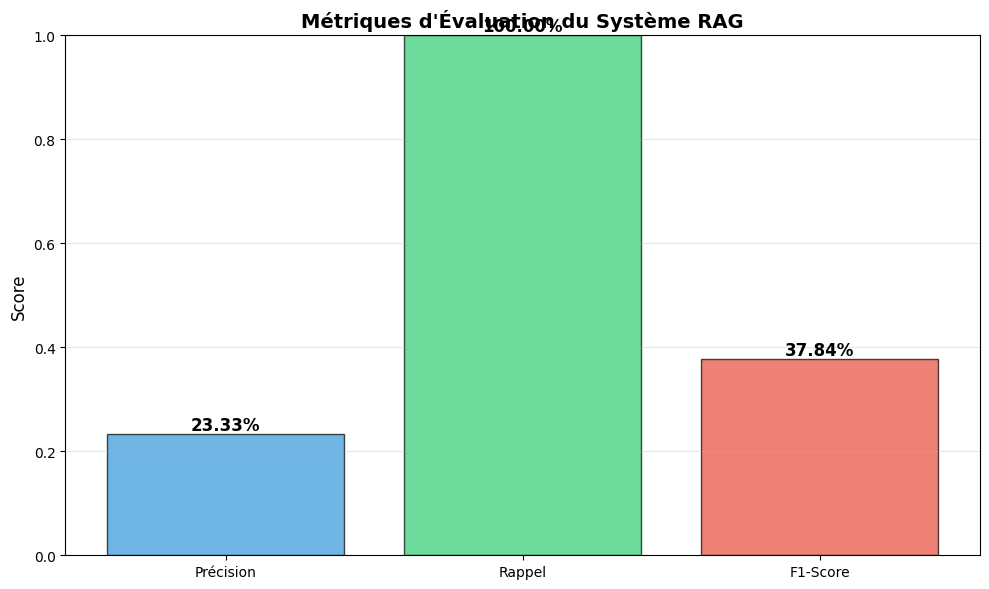

 Graphique sauvegardé: ./data/processed/corpus_distribution.png


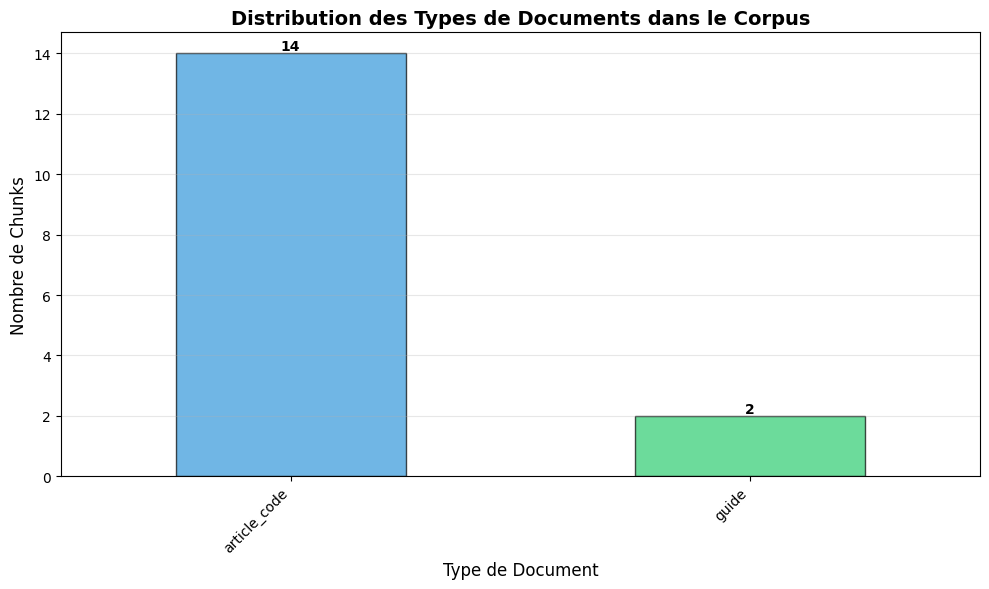

 Graphique sauvegardé: ./data/processed/chunk_sizes.png


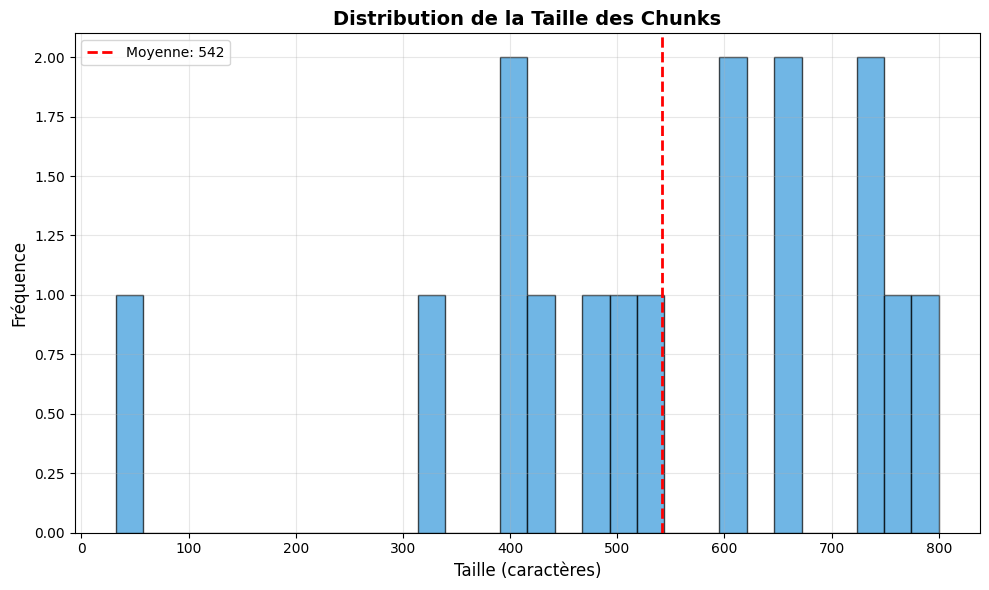


EXPORT DES RÉSULTATS

  Génération du rapport d'évaluation...


╔══════════════════════════════════════════════════════════════════════════════╗
║                    RAPPORT D'ÉVALUATION - CHATBOT JURIDIQUE                  ║
╚══════════════════════════════════════════════════════════════════════════════╝

Date de génération: 05/12/2025 23:50:58

═══════════════════════════════════════════════════════════════════════════════

1. MÉTRIQUES DE RETRIEVAL
──────────────────────────

• Précision moyenne: 23.33%
 └─ Proportion de documents récupérés qui sont pertinents

• Rappel moyen: 100.00%
 └─ Proportion de documents pertinents qui ont été récupérés

• F1-Score: 37.84%
 └─ Moyenne harmonique de la précision et du rappel

Interprétation:
 Précision faible - Trop de documents non pertinents
 Excellent rappel - La plupart des documents pertinents sont trouvés

═══════════════════════════════════════════════════════════════════════════════

2. GESTION HORS PÉRIMÈTRE
────────────────────────

In [34]:
 #============================================================================
# SECTION 12: VISUALISATIONS


print("="*80)
print("GÉNÉRATION DES VISUALISATIONS")
print("="*80)

class Visualizer:
    """Visualisations pour le rapport"""

    @staticmethod
    def plot_retrieval_metrics(metrics: Dict, save_path: str = None):
        """Graphique des métriques"""

        fig, ax = plt.subplots(figsize=(10, 6))

        metric_names = ['Précision', 'Rappel', 'F1-Score']
        values = [metrics['precision'], metrics['recall'], metrics['f1_score']]
        colors = ['#3498db', '#2ecc71', '#e74c3c']

        bars = ax.bar(metric_names, values, color=colors, alpha=0.7, edgecolor='black')

        # Ajouter les valeurs
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2%}',
                   ha='center', va='bottom', fontsize=12, fontweight='bold')

        ax.set_ylim(0, 1)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Métriques d\'Évaluation du Système RAG', fontsize=14, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Graphique sauvegardé: {save_path}")

        plt.show()

    @staticmethod
    def plot_corpus_distribution(chunks: List[Document], save_path: str = None):
        """Distribution des types de documents"""

        types = [chunk.metadata.get('type', 'unknown') for chunk in chunks]
        type_counts = pd.Series(types).value_counts()

        fig, ax = plt.subplots(figsize=(10, 6))

        colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
        type_counts.plot(kind='bar', ax=ax, color=colors[:len(type_counts)], alpha=0.7, edgecolor='black')

        ax.set_title('Distribution des Types de Documents dans le Corpus', fontsize=14, fontweight='bold')
        ax.set_xlabel('Type de Document', fontsize=12)
        ax.set_ylabel('Nombre de Chunks', fontsize=12)
        ax.grid(axis='y', alpha=0.3)
        plt.xticks(rotation=45, ha='right')

        # Ajouter les valeurs
        for i, v in enumerate(type_counts.values):
            ax.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f" Graphique sauvegardé: {save_path}")

        plt.show()

    @staticmethod
    def plot_chunk_size_distribution(chunks: List[Document], save_path: str = None):
        """Distribution de la taille des chunks"""

        sizes = [len(chunk.page_content) for chunk in chunks]

        fig, ax = plt.subplots(figsize=(10, 6))

        ax.hist(sizes, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
        ax.axvline(np.mean(sizes), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {np.mean(sizes):.0f}')

        ax.set_title('Distribution de la Taille des Chunks', fontsize=14, fontweight='bold')
        ax.set_xlabel('Taille (caractères)', fontsize=12)
        ax.set_ylabel('Fréquence', fontsize=12)
        ax.legend()
        ax.grid(alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f" Graphique sauvegardé: {save_path}")

        plt.show()

# Créer les visualisations
viz = Visualizer()

print("\n Génération des graphiques...\n")

viz.plot_retrieval_metrics(
    retrieval_metrics,
    save_path=f"{Config.PROCESSED_DIR}/metrics.png"
)

viz.plot_corpus_distribution(
    chunks,
    save_path=f"{Config.PROCESSED_DIR}/corpus_distribution.png"
)

viz.plot_chunk_size_distribution(
    chunks,
    save_path=f"{Config.PROCESSED_DIR}/chunk_sizes.png"
)

print()


# SECTION 13: EXPORT DES RÉSULTATS


print("="*80)
print("EXPORT DES RÉSULTATS")
print("="*80)

class ResultExporter:
    """Export des résultats pour le rapport"""

    @staticmethod
    def export_evaluation_report(retrieval_metrics: Dict, out_of_scope_rate: float):
        """Générer un rapport d'évaluation"""

        report = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    RAPPORT D'ÉVALUATION - CHATBOT JURIDIQUE                  ║
╚══════════════════════════════════════════════════════════════════════════════╝

Date de génération: {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}

═══════════════════════════════════════════════════════════════════════════════

1. MÉTRIQUES DE RETRIEVAL
──────────────────────────

• Précision moyenne: {retrieval_metrics['precision']:.2%}
  └─ Proportion de documents récupérés qui sont pertinents

• Rappel moyen: {retrieval_metrics['recall']:.2%}
  └─ Proportion de documents pertinents qui ont été récupérés

• F1-Score: {retrieval_metrics['f1_score']:.2%}
  └─ Moyenne harmonique de la précision et du rappel

Interprétation:
{ResultExporter._interpret_retrieval(retrieval_metrics)}

═══════════════════════════════════════════════════════════════════════════════

2. GESTION HORS PÉRIMÈTRE
─────────────────────────

• Taux de refus approprié: {out_of_scope_rate:.2%}
  └─ Capacité à identifier et refuser les questions hors domaine

Interprétation:
{ResultExporter._interpret_out_of_scope(out_of_scope_rate)}

═══════════════════════════════════════════════════════════════════════════════

3. STATISTIQUES DU CORPUS
─────────────────────────

• Nombre d'articles du Code du Travail: {len(code_travail)}
• Nombre de guides CNIL: {len(cnil_guides)}
• Nombre total de chunks: {len(chunks)}
• Taille moyenne des chunks: {np.mean([len(c.page_content) for c in chunks]):.0f} caractères
• Modèle d'embeddings: {Config.EMBEDDING_MODEL}
• Base vectorielle: FAISS
• Top-K retrieval: {Config.TOP_K}

═══════════════════════════════════════════════════════════════════════════════

4. RECOMMANDATIONS
──────────────────

{ResultExporter._generate_recommendations(retrieval_metrics, out_of_scope_rate)}

═══════════════════════════════════════════════════════════════════════════════

5. LIMITATIONS IDENTIFIÉES
──────────────────────────

• Corpus limité à un échantillon du Code du Travail
• Pas de jurisprudence intégrée
• Mode simulation LLM (sans API)
• Pas de mise à jour en temps réel des textes légaux

═══════════════════════════════════════════════════════════════════════════════

6. AMÉLIORATIONS FUTURES
────────────────────────

✓ Intégrer l'API PISTE pour un corpus complet
✓ Ajouter la jurisprudence française
✓ Implémenter un re-ranker pour améliorer la pertinence
✓ Ajouter un système de feedback utilisateur
✓ Fine-tuner le modèle d'embeddings sur du texte juridique
✓ Intégrer un vrai LLM via API

═══════════════════════════════════════════════════════════════════════════════
"""

        output_path = f"{Config.PROCESSED_DIR}/rapport_evaluation.txt"
        with open(output_path, 'w', encoding='utf-8') as f:
            f.write(report)

        print(report)
        print(f" Rapport sauvegardé: {output_path}")

        return report

    @staticmethod
    def _interpret_retrieval(metrics: Dict) -> str:
        """Interpréter les métriques de retrieval"""
        precision = metrics['precision']
        recall = metrics['recall']

        interpretations = []

        if precision >= 0.8:
            interpretations.append(" Excellente précision - Les documents récupérés sont très pertinents")
        elif precision >= 0.6:
            interpretations.append("  Précision acceptable - Quelques documents non pertinents récupérés")
        else:
            interpretations.append(" Précision faible - Trop de documents non pertinents")

        if recall >= 0.8:
            interpretations.append(" Excellent rappel - La plupart des documents pertinents sont trouvés")
        elif recall >= 0.6:
            interpretations.append("  Rappel acceptable - Certains documents pertinents manquent")
        else:
            interpretations.append(" Rappel faible - Beaucoup de documents pertinents manqués")

        return "\n".join(interpretations)

    @staticmethod
    def _interpret_out_of_scope(rate: float) -> str:
        """Interpréter le taux hors périmètre"""
        if rate >= 0.9:
            return " Excellent - Le système refuse correctement les questions hors périmètre"
        elif rate >= 0.7:
            return "  Acceptable - Quelques améliorations possibles dans la détection"
        else:
            return " Insuffisant - Le système doit mieux gérer les questions hors domaine"

    @staticmethod
    def _generate_recommendations(retrieval_metrics: Dict, out_of_scope_rate: float) -> str:
        """Générer des recommandations"""
        recs = []

        if retrieval_metrics['precision'] < 0.7:
            recs.append("• Améliorer le chunking pour des passages plus cohérents")
            recs.append("• Tester d'autres modèles d'embeddings")

        if retrieval_metrics['recall'] < 0.7:
            recs.append("• Augmenter le top-K pour récupérer plus de documents")
            recs.append("• Enrichir le corpus avec plus d'articles")

        if out_of_scope_rate < 0.8:
            recs.append("• Renforcer le prompt système pour mieux gérer les refus")
            recs.append("• Ajouter des exemples de questions hors périmètre")

        if not recs:
            recs.append(" Les performances actuelles sont satisfaisantes")
            recs.append("• Continuer à enrichir le corpus")
            recs.append("• Collecter du feedback utilisateur")

        return "\n".join(recs)

    @staticmethod
    def export_conversation_history():
        """Exporter l'historique des conversations"""
        history = rag_pipeline.conversation_history

        output_path = f"{Config.PROCESSED_DIR}/conversation_history.json"
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(history, f, ensure_ascii=False, indent=2)

        print(f" Historique sauvegardé: {output_path}")
        print(f"   {len(history)} conversations enregistrées")

# Générer les exports
exporter = ResultExporter()

print("\n  Génération du rapport d'évaluation...\n")
exporter.export_evaluation_report(retrieval_metrics, out_of_scope_rate)

print("\nExport de l'historique...\n")
exporter.export_conversation_history()

print()


In [35]:

# SECTION 14: INTERFACE GRADIO (VERSION UNIVERSELLE)


print("="*80)
print("CRÉATION DE L'INTERFACE CHATBOT")
print("="*80)

def create_chatbot_interface():
    """Créer l'interface Gradio complète"""

    def chat_function(message, history):
        """Fonction de chat pour Gradio"""

        # Vérifier le message
        if not message or len(message.strip()) < 3:
            new_history = history if history else []
            new_history.append([message, " Veuillez poser une question valide (minimum 3 caractères)."])
            return new_history

        # Traiter la requête
        result = rag_pipeline.process_query(message)

        # Formater la réponse
        response = rag_pipeline.format_response(result)

        # Ajouter à l'historique
        new_history = history if history else []
        new_history.append([message, response])

        return new_history

    def clear_chat():
        """Effacer l'historique"""
        return None

    def set_example(example):
        """Définir un exemple"""
        return example

    def get_stats():
        """Obtenir les statistiques"""
        stats = rag_pipeline.get_statistics()
        return f"""
 **Statistiques du système:**

- Nombre de questions traitées: {stats['total_queries']}
- Moyenne de sources par question: {stats['avg_sources_per_query']:.1f}
- Total de sources consultées: {stats['total_sources_consulted']}
        """

    # Interface Gradio
    with gr.Blocks(title="Chatbot Juridique") as demo:

        gr.Markdown("""
        # 🏛️ Chatbot Juridique - Droit du Travail Français

        Assistant virtuel spécialisé dans le Code du Travail et le RGPD
        """)

        gr.Markdown("""
        ###  Bienvenue !

        Ce chatbot vous aide à comprendre vos droits en matière de droit du travail.

         **Important** : Ce service est à titre informatif uniquement.
        Pour des conseils personnalisés, consultez un avocat.
        """)

        with gr.Row():
            with gr.Column(scale=2):
                # Chatbot sans le paramètre 'type'
                chatbot = gr.Chatbot(
                    label="Conversation",
                    height=500
                )

                msg = gr.Textbox(
                    label="Votre question",
                    placeholder="Ex: Quelle est la durée légale du travail ?",
                    lines=2
                )

                with gr.Row():
                    submit_btn = gr.Button(" Envoyer", variant="primary")
                    clear_btn = gr.Button(" Effacer")

            with gr.Column(scale=1):
                gr.Markdown("###  Questions suggérées")

                examples = [
                    "Quelle est la durée légale du travail ?",
                    "Quels sont mes droits au congé payé ?",
                    "Qu'est-ce que le harcèlement moral ?",
                    "Quels sont les cas de discrimination ?",
                    "Durée du congé maternité ?",
                    "Licenciement économique ?",
                    "CDD : quels cas ?",
                    "CNIL et données au travail ?"
                ]

                for example in examples:
                    btn = gr.Button(example, size="sm")
                    btn.click(fn=lambda x=example: x, outputs=msg)

                gr.Markdown("---")

                stats_btn = gr.Button(" Voir statistiques")
                stats_output = gr.Markdown()

        gr.Markdown("""
        ---
        ###  Technologies

        - **RAG** : Retrieval-Augmented Generation
        - **Embeddings** : Sentence-CamemBERT
        - **Base vectorielle** : FAISS
        - **Sources** : Code du Travail + CNIL

        ---

        **Projet NLP - 2024**
        """)

        # Événements
        def submit_and_clear(message, history):
            """Soumettre et effacer le champ"""
            new_history = chat_function(message, history)
            return new_history, ""

        submit_btn.click(
            fn=submit_and_clear,
            inputs=[msg, chatbot],
            outputs=[chatbot, msg]
        )

        msg.submit(
            fn=submit_and_clear,
            inputs=[msg, chatbot],
            outputs=[chatbot, msg]
        )

        clear_btn.click(
            fn=clear_chat,
            outputs=[chatbot]
        )

        stats_btn.click(
            fn=get_stats,
            outputs=[stats_output]
        )

    return demo

# Créer l'interface
print(" Création de l'interface...\n")

demo = create_chatbot_interface()

print("="*80)
print("INTERFACE PRÊTE")
print("="*80)
print("""
 Le chatbot est prêt !

L'interface va se lancer dans quelques secondes...
Un lien public sera généré pour partager l'application.
""")

# Lancement avec gestion du port
import socket

def find_free_port(start=7860, max_attempts=10):
    for port in range(start, start + max_attempts):
        try:
            s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            s.bind(('', port))
            s.close()
            return port
        except:
            continue
    return None

port = find_free_port()

if port:
    print(f"\n🔌 Port: {port}")
    print(" Lancement...\n")

    try:
        demo.launch(
            share=True,
            server_port=port,
            show_error=True,
            quiet=False
        )
    except Exception as e:
        print(f" Erreur: {e}")
        print("\n Solution: Runtime > Restart runtime, puis Run all")
else:
    print(" Aucun port disponible")
    print(" Solution: Runtime > Disconnect and delete runtime")

CRÉATION DE L'INTERFACE CHATBOT
 Création de l'interface...

INTERFACE PRÊTE

 Le chatbot est prêt !

L'interface va se lancer dans quelques secondes...
Un lien public sera généré pour partager l'application.


🔌 Port: 7861
 Lancement...

IMPORTANT: You are using gradio version 4.13.0, however version 4.44.1 is available, please upgrade.
--------
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://aedba6570457ac7c8d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
